In [117]:
import numpy as np
import cv2
import os
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import random
from PIL import Image

In [118]:
def to_Matrix(image):
    img = Image.open(image)
    color = 1
    pixelVal = img.load()
    if type(pixelVal[0,0]) == int:
      color = 0
    imgmatrix = []
    imagesize = img.size
    for width in range(int(imagesize[0])):
        row = []
        for height in range(int(imagesize[1])):
                row.append((pixelVal[width,height]))
        imgmatrix.append(row)
    return imgmatrix,imagesize[0],color

In [119]:
def Arnold_E(image, key):
    img = cv2.imread(image)
    r, c, co = img.shape
    e_img = img
    for i in range (0,key):
        new_image = np.zeros([r, c, co])
        for x in range(0, r):
            for y in range(0, c):
                new_image[x][y] = e_img[(x+y)%r][(x+2*y)%c]
        e_img = new_image
    cv2.imwrite(image.split('.')[0] + "_AE.png", e_img)
    return e_img

In [120]:
import cv2
import numpy as np
import math

def Arnold_D(image, key):
    img = cv2.imread(image)
    rows, cols, channels = img.shape
    n = rows
    dim = rows
    if dim % 2 == 0 and 5 ** int(round(math.log(dim / 2, 5))) == int(dim / 2):
        limit = 3 * dim
    elif 5 ** int(round(math.log(dim, 5))) == int(dim):
        limit = 2 * dim
    elif dim % 6 == 0 and 5 ** int(round(math.log(dim / 6, 5))) == int(dim / 6):
        limit = 2 * dim
    else:
        limit = int(12 * dim / 7)
    for i in range(key):
        new_image = np.zeros([rows, cols, channels], dtype=np.uint8)
        for x in range(0, rows):
            for y in range(0, cols):
                new_image[(x + y) % n][(x + 2 * y) % n] = img[x][y]
        img = new_image

    cv2.imwrite(image.split('_')[0] + "_AD.png",img)
    return img

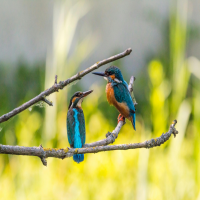

In [122]:
img = cv2.imread("img1.png")
cv2_imshow(img)
key = 42

In [123]:
im = cv2.imread("img1.png")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(gray)

[[180 179 179 ... 177 177 177]
 [179 179 179 ... 177 177 177]
 [180 179 178 ... 177 177 177]
 ...
 [230 231 233 ... 226 235 239]
 [231 233 234 ... 229 237 240]
 [233 234 234 ... 233 239 241]]


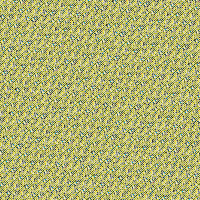

In [124]:
Arnold_EIm = Arnold_E("img1.png", key)
cv2_imshow(Arnold_EIm)

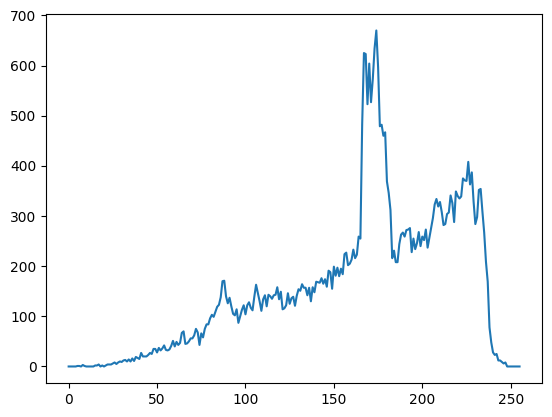

In [125]:
img = cv2.imread('img1.png',0)
histr = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

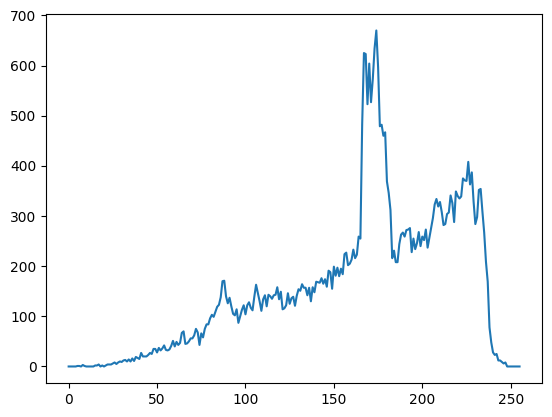

In [126]:
img = cv2.imread('img1_AE.png',0)
histr = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

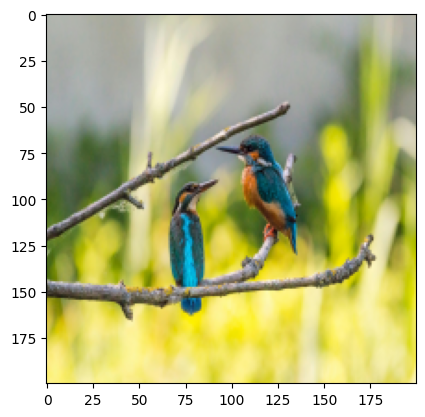

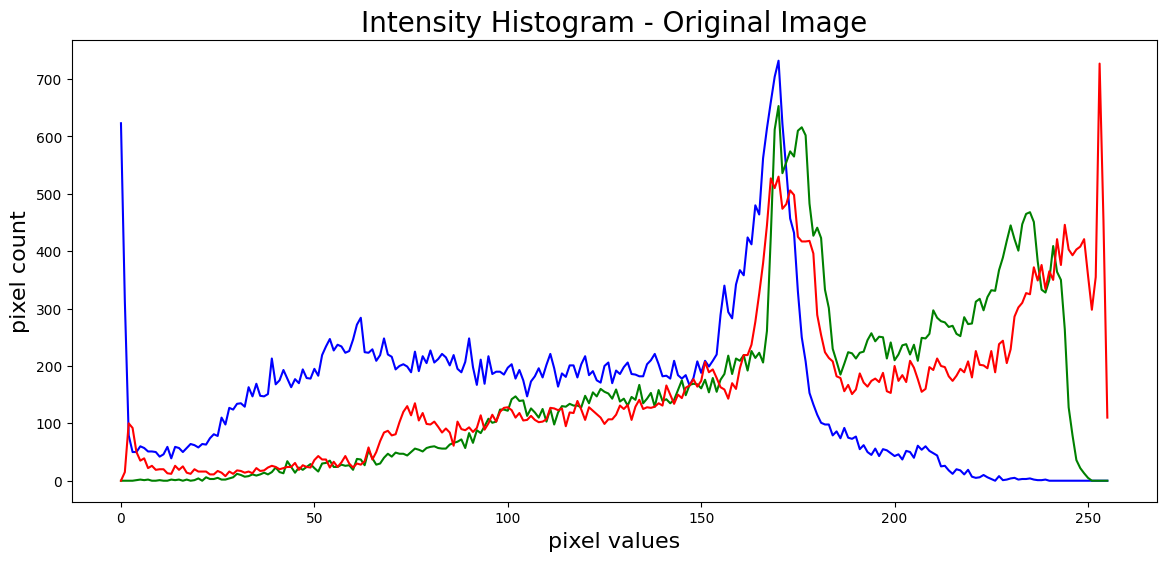

In [127]:
image = "img1"
ext = ".png"
img = cv2.imread(image + ext,1)
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))

plt.figure(figsize=(14,6))
histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue')
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
plt.plot(histogram_green, color='green')
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
plt.plot(histogram_red, color='red')
plt.title('Intensity Histogram - Original Image', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16)
plt.show()

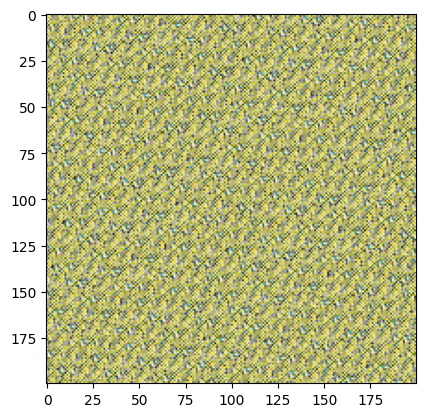

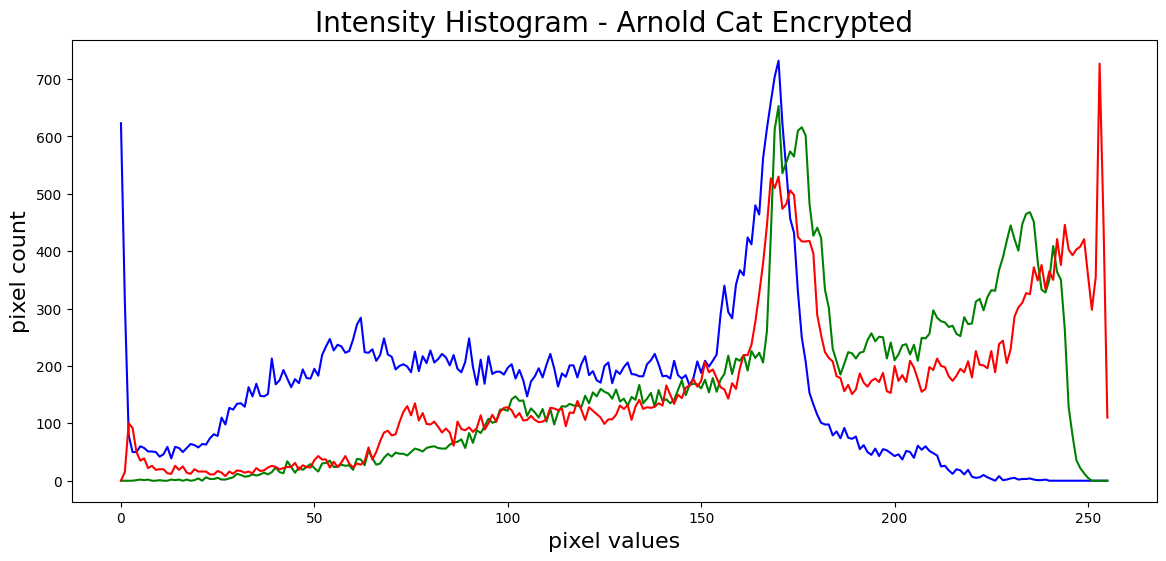

In [128]:
image = "img1_AE"
ext = ".png"
img = cv2.imread(image + ext,1)
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))

plt.figure(figsize=(14,6))
histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue')
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
plt.plot(histogram_green, color='green')
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
plt.plot(histogram_red, color='red')
plt.title('Intensity Histogram - Arnold Cat Encrypted', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16)
plt.show()

In [129]:
def makeHenonMap(dim, key):
    x = key[0]
    y = key[1]
    seqSize = dim * dim * 8
    bits = []
    decArray = []
    HMatrix = []
    for i in range(seqSize):
        xi = y + 1 - 1.4 * x**2
        yi = 0.3 * x

        x = xi
        y = yi
        if xi <= 0.4:
            bit = 0
        else:
            bit = 1
        bits.append(bit)
        if i % 8 == 7:
            decimal = 0
            for bit in bits:
                decimal = decimal * 2 + int(bit)
            decArray.append(decimal)
            bits = []
        decArraySize = dim*8
        if i % decArraySize == decArraySize-1:
            HMatrix.append(decArray)
            decArray = []
    return HMatrix

In [130]:
def HenonE(image,key):
    imgMatrix, dim, iscolor = to_Matrix(image)
    transformMatrix = makeHenonMap(dim, key)
    newMatrix = []
    for i in range(dim):
        row = []
        for j in range(dim):
            if iscolor:
                row.append(tuple([transformMatrix[i][j] ^ x for x in imgMatrix[i][j]]))
            else:
                row.append(transformMatrix[i][j] ^ imgMatrix[i][j])

        newMatrix.append(row)

    if iscolor:
      im = Image.new("RGB", (dim, dim))
    else:
      im = Image.new("L", (dim, dim))

    pix = im.load()
    for x in range(dim):
        for y in range(dim):
            pix[x, y] = newMatrix[x][y]
    im.save(image.split('.')[0] + "_HE.png", "PNG")

In [131]:
def HenonD(imageEnc, key):
    imgMatrix, dim, color = to_Matrix(imageEnc)
    transformMatrix = makeHenonMap(dim, key)
    pil_im = Image.open(imageEnc, 'r')
    imshow(np.asarray(pil_im))
    henonDImage = []
    for i in range(dim):
        row = []
        for j in range(dim):
            if color:
                row.append(tuple([transformMatrix[i][j] ^ x for x in imgMatrix[i][j]]))
            else:
                row.append(transformMatrix[i][j] ^ imgMatrix[i][j])

        henonDImage.append(row)

    if color:
        im = Image.new("RGB", (dim, dim))
    else:
        im = Image.new("L", (dim, dim)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dim):
        for y in range(dim):
            pix[x, y] = henonDImage[x][y]
    im.save(imageEnc.split('_')[0] + "_HD.png", "PNG")

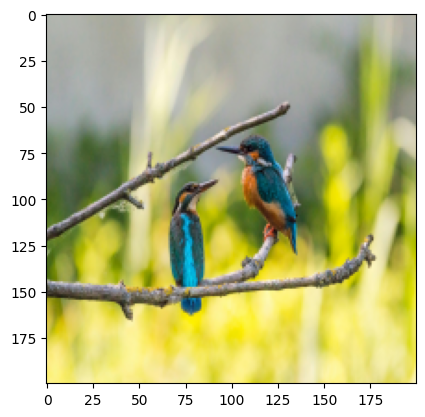

In [132]:
key = (0.1,0.1)
pil_im = Image.open("img1.png", 'r')
imshow(np.asarray(pil_im))

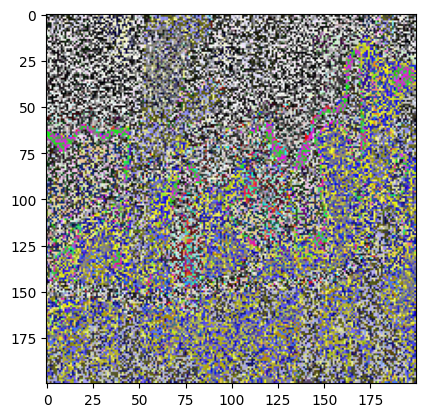

In [133]:
HenonE("img1.png", key)
im = Image.open("img1" + "_HE.png", 'r')
imshow(np.asarray(im))

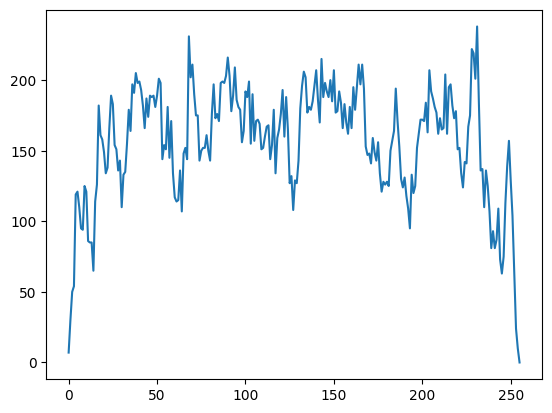

In [134]:
img = cv2.imread('img1_HE.png',0)
histr = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

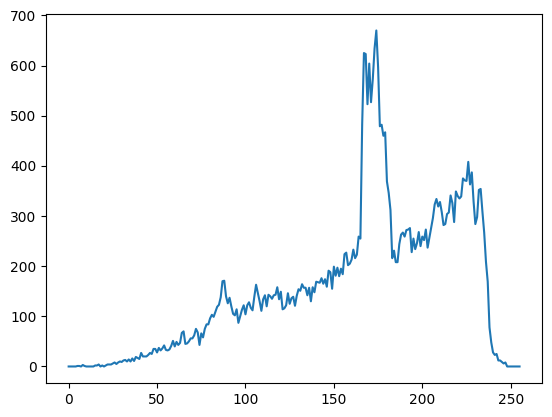

In [135]:
img = cv2.imread('img1.png',0)
histr = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

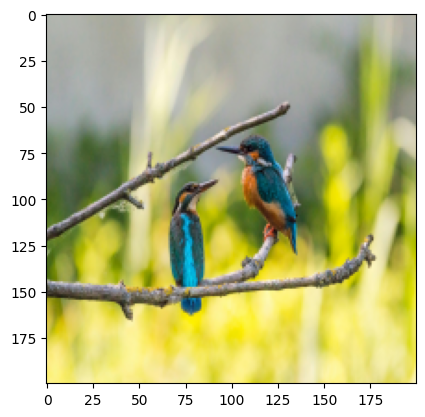

In [136]:
HenonD("img1" + "_HE.png", key)
im = Image.open("img1" + "_HD.png", 'r')
imshow(np.asarray(im))

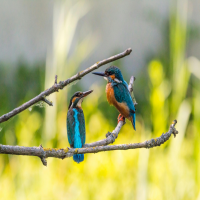

In [137]:
img = cv2.imread("img1.png")
cv2_imshow(img)
key1 = 42

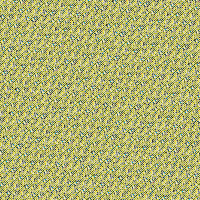

In [138]:
Arnold_EIm = Arnold_E("img1.png", key1)
cv2_imshow(Arnold_EIm)

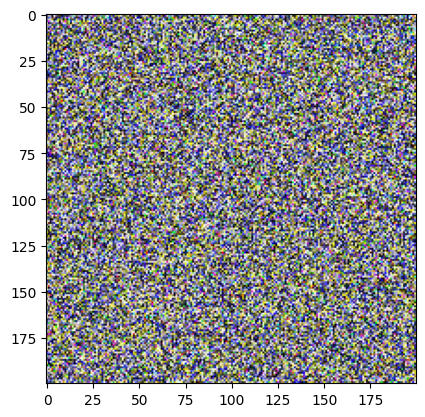

In [139]:
key2 = (0.5,0.5)
HenonE("img1_AE.png", key2)
im = Image.open("img1_AE" + "_HE.png", 'r')
imshow(np.asarray(im))

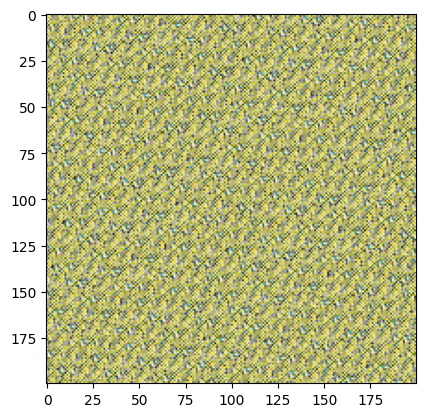

In [140]:
HenonD("img1_AE" + "_HE.png", key2)
im = Image.open("img1_HD.png", 'r')
imshow(np.asarray(im))

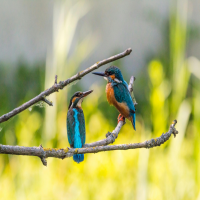

In [141]:
Arnold_DIm = Arnold_D("img1_HD.png", key1)
cv2_imshow(Arnold_DIm)

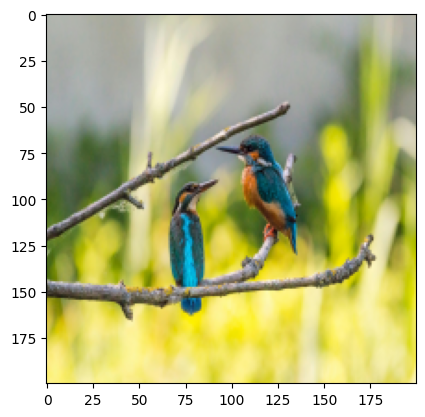

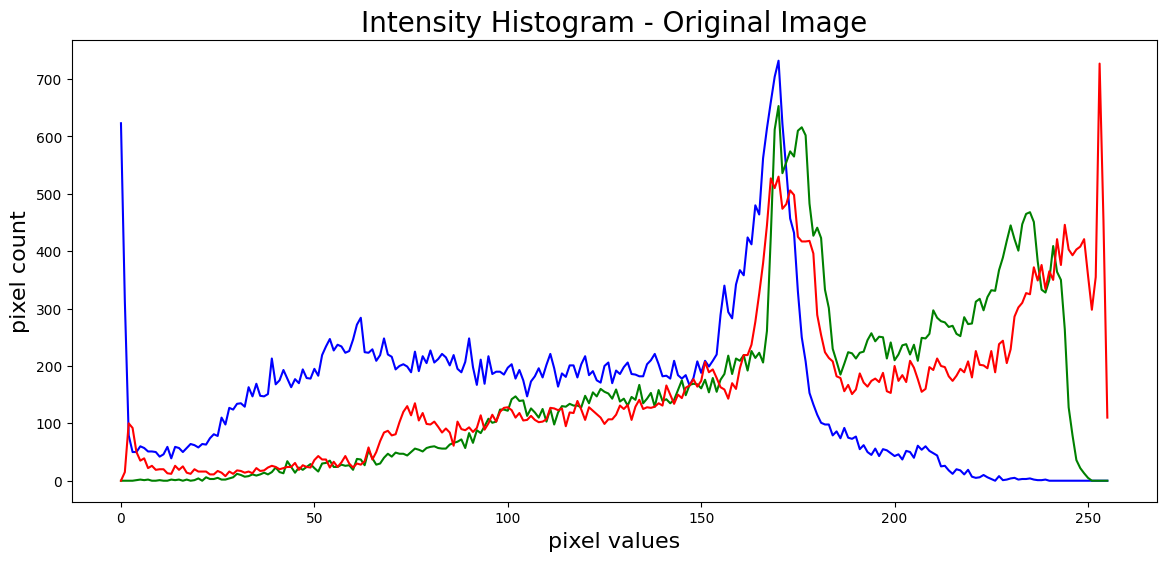

In [142]:
image = "img1"
ext = ".png"
img = cv2.imread(image + ext,1)
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))
plt.figure(figsize=(14,6))

histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue')
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
plt.plot(histogram_green, color='green')
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
plt.plot(histogram_red, color='red')
plt.title('Intensity Histogram - Original Image', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16)
plt.show()

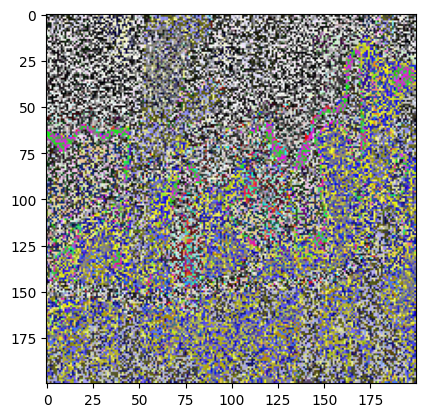

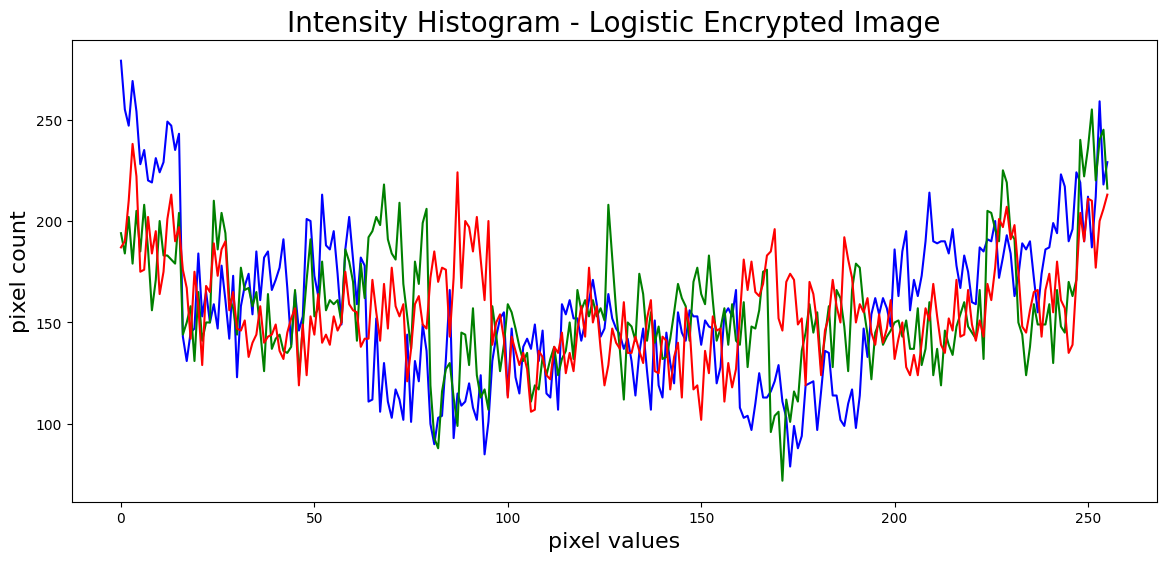

In [143]:
image = "img1_HE"
ext = ".png"
img = cv2.imread(image + ext,1)
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))
plt.figure(figsize=(14,6))

histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue')
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
plt.plot(histogram_green, color='green')
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
plt.plot(histogram_red, color='red')
plt.title('Intensity Histogram - Logistic Encrypted Image', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16)
plt.show()

In [144]:
key2 = (0.5,0.5)

In [145]:
def ArnoldHenonE(key1, key2):
    AE = Arnold_E("img1.png", key1)
    cv2_imshow(AE)
    HenonE("img1_AE.png", key2)
    im = Image.open("img1_AE" + "_HE.png", 'r')
    imshow(np.asarray(im))
    image = "img1_AE_HE"
    ext = ".png"
    img = cv2.imread(image + ext,1)
    pil_im = Image.open(image + ext, 'r')
    imshow(np.asarray(pil_im))
    plt.figure(figsize=(14,6))
    histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histogram_blue, color='blue')
    histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
    plt.plot(histogram_green, color='green')
    histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
    plt.plot(histogram_red, color='red')
    plt.title('Intensity Histogram - Logistic Encrypted Image', fontsize=20)
    plt.xlabel('pixel values', fontsize=16)
    plt.ylabel('pixel count', fontsize=16)
    plt.show()
    img = cv2.imread('img1_AE_HE.png',0)
    histr = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histr)
    plt.show()


def ArnoldHenonD(key1, key2):
    HenonD("img1_AE" + "_HE.png", key2)
    im = Image.open("img1_HD.png", 'r')
    imshow(np.asarray(im))
    Arnold_DIm = Arnold_D("img1_HD.png", key1)
    cv2_imshow(Arnold_DIm)
    image = "img1_HD"
    ext = ".png"
    img = cv2.imread(image + ext,1)
    pil_im = Image.open(image + ext, 'r')
    imshow(np.asarray(pil_im))
    plt.figure(figsize=(14,6))
    histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histogram_blue, color='blue')
    histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
    plt.plot(histogram_green, color='green')
    histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
    plt.plot(histogram_red, color='red')
    plt.title('Intensity Histogram - Logistic Encrypted Image', fontsize=20)
    plt.xlabel('pixel values', fontsize=16)
    plt.ylabel('pixel count', fontsize=16)
    plt.show()
    img = cv2.imread('img1.png',0)
    histr = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histr)
    plt.show()

In [146]:
# Diffie-Hellman Code


def prime_checker(p):
    # Checks If the number entered is a Prime Number or not
    if p < 1:
        return -1
    elif p > 1:
        if p == 2:
            return 1
        for i in range(2, p):
            if p % i == 0:
                return -1
            return 1


def primitive_check(g, p, L):
    # Checks If The Entered Number Is A Primitive Root Or Not
    for i in range(1, p):
        L.append(pow(g, i) % p)
    for i in range(1, p):
        if L.count(i) > 1:
            L.clear()
            return -1
        return 1


l = []
while 1:
    P = int(input("Enter P : "))
    if prime_checker(P) == -1:
        print("Number Is Not Prime, Please Enter Again!")
        continue
    break

while 1:
    G = int(input(f"Enter The Primitive Root Of {P} : "))
    if primitive_check(G, P, l) == -1:
        print(f"Number Is Not A Primitive Root Of {P}, Please Try Again!")
        continue
    break

# Private Keys
x1, x2 = int(input("Enter The Private Key Of User 1 : ")), int(
    input("Enter The Private Key Of User 2 : "))
while 1:
    if x1 >= P or x2 >= P:
        print(f"Private Key Of Both The Users Should Be Less Than {P}!")
        continue
    break

# Calculate Public Keys
y1, y2 = pow(G, x1) % P, pow(G, x2) % P

# Generate Secret Keys
k1, k2 = pow(y2, x1) % P, pow(y1, x2) % P

print(f"\nSecret Key For User 1 Is {k1}\nSecret Key For User 2 Is {k2}\n")

if k1 == k2:
    print("Keys Have Been Exchanged Successfully")
else:
    print("Keys Have Not Been Exchanged Successfully")

Enter P : 59
Enter The Primitive Root Of 59 : 42
Enter The Private Key Of User 1 : 25
Enter The Private Key Of User 2 : 36

Secret Key For User 1 Is 17
Secret Key For User 2 Is 17

Keys Have Been Exchanged Successfully


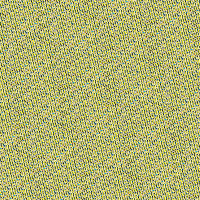

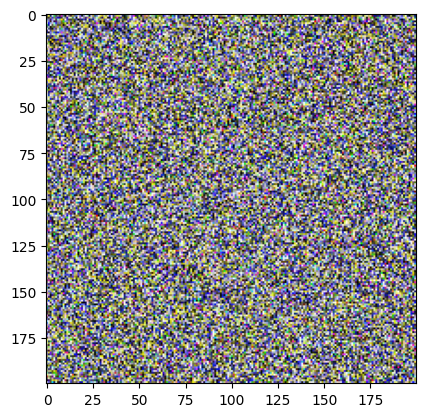

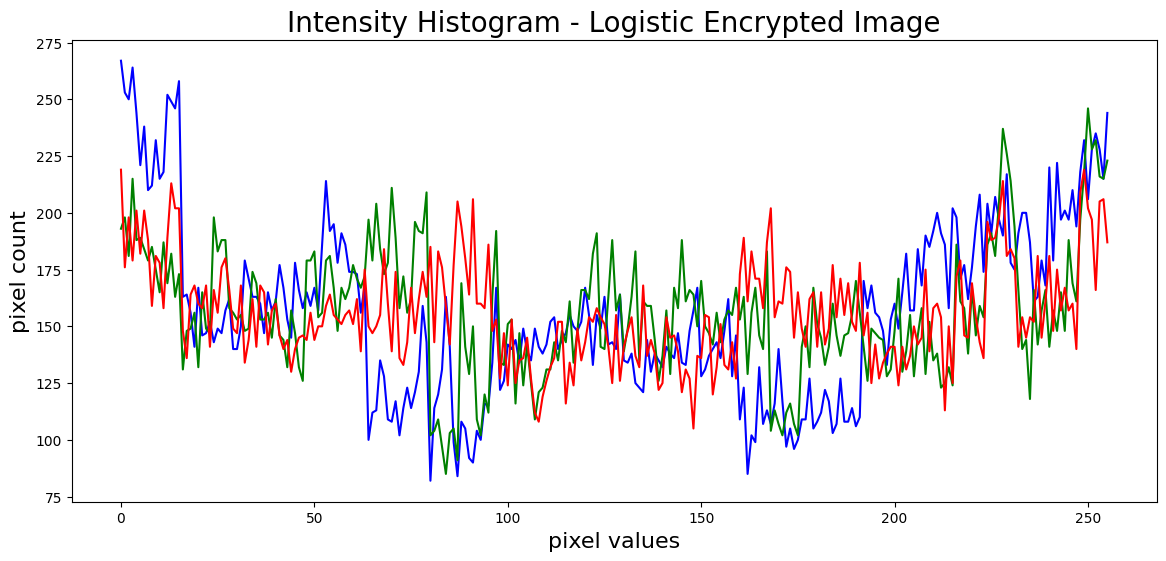

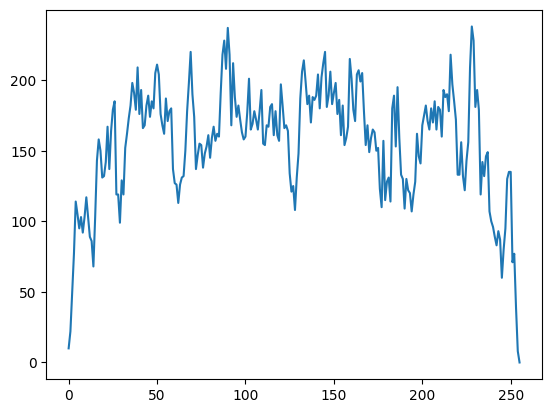

In [147]:
ArnoldHenonE(k1, key2)

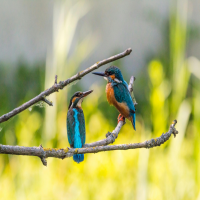

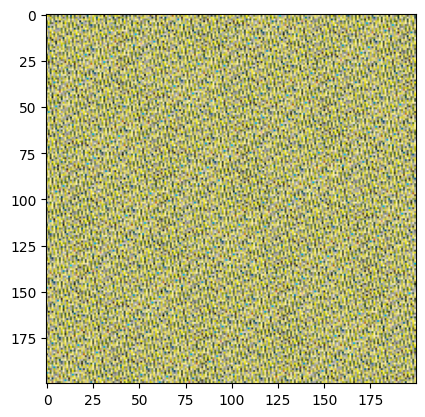

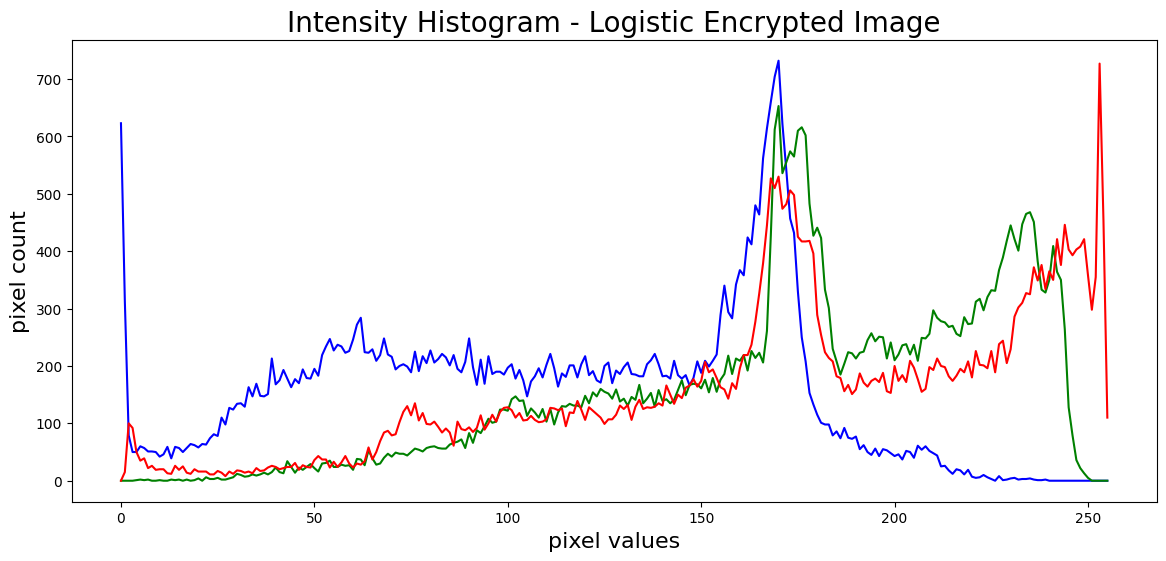

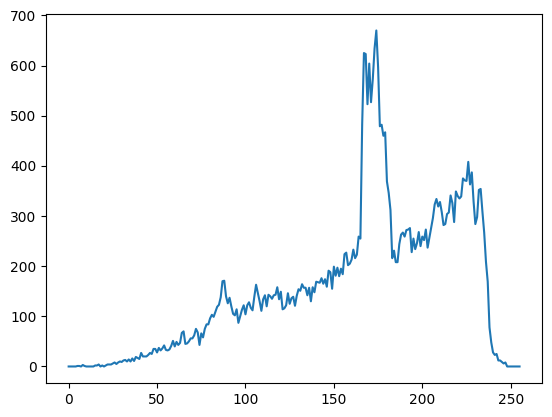

In [148]:
ArnoldHenonD(k2, key2)